In [1]:
# import necessary tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import precision_recall_curve

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep='\t', index_col=0)


In [3]:
annotations = pd.read_csv('attack_annotations.tsv', sep='\t')

In [4]:
print('There are', len(annotations['rev_id'].unique()), 'unique rev_id')

There are 115864 unique rev_id


In [5]:
# labels a comment as an attack if the majority of annotators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

In [6]:
# insert labels in comments
comments['attack'] = labels

In [7]:
# Parsing: remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [8]:
# holdout

holdout_comments = pd.read_csv('attack_annotated_comments_prova.csv', index_col=0)
holdout_annotations = pd.read_csv('attack_annotations_prova.csv')

holdout_labels = holdout_annotations.groupby('rev_id')['attack'].mean() > 0.5

holdout_comments['attack'] = holdout_labels

holdout_comments['comment'] = holdout_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
holdout_comments['comment'] = holdout_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [9]:
# Presentation

print('This is your DataFrame:\n')
print(comments.head())
print('These are the head of the comments classified as an attack\n')
print(comments.query('attack')['comment'].head())

This is your DataFrame:

                                                  comment  year  logged_in  \
rev_id                                                                       
37675   `- This is not ``creative``.  Those are the di...  2002      False   
44816   `  :: the term ``standard model`` is itself le...  2002      False   
49851     True or false, the situation as of March 200...  2002      False   
89320    Next, maybe you could work on being less cond...  2002       True   
93890                This page will need disambiguation.   2002       True   

             ns  sample  split  attack  
rev_id                                  
37675   article  random  train   False  
44816   article  random  train   False  
49851   article  random  train   False  
89320   article  random    dev   False  
93890   article  random  train   False  
These are the head of the comments classified as an attack

rev_id
801279             Iraq is not good  ===  ===  USA is bad   
2702703      

In [10]:
# create y which is the outcome label the model has to learn
X = comments['comment']
y = comments['attack']

X_extverif = holdout_comments['comment']
y_extverif = holdout_comments['attack']

In [11]:
# split the dataframe into training and testing data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.33, random_state=53)

In [12]:
# Setup the pipeline
steps = [('vec', CountVectorizer(max_features=50000, analyzer='char', ngram_range=(1, 5))),
         ('tfidf', TfidfTransformer(norm='l2', sublinear_tf=True)),
         ('clf', LogisticRegression(C=10))]

pipeline = Pipeline(steps)

In [13]:
# Fit to the training set
pipeline.fit(X_train, y_train)

print(pipeline)


Pipeline(steps=[('vec', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 5), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [14]:
# Predict the labels of the test set: y_pred
y_pred = pipeline.predict(X_test)

In [15]:
# Compute and print metrics
print("Accuracy: {}".format(pipeline.score(X_test, y_test)))
print(metrics.classification_report(y_test, y_pred))


Accuracy: 0.9484778742546291
             precision    recall  f1-score   support

      False       0.96      0.98      0.97     33671
       True       0.85      0.69      0.76      4565

avg / total       0.95      0.95      0.95     38236



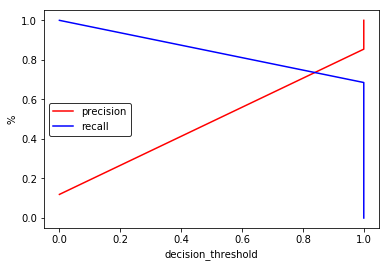

In [16]:
# building the graph for classification report
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
decision_threshold = np.append(thresholds, 1)

plt.plot(decision_threshold, precision, color='red')
plt.plot(decision_threshold, recall, color='blue')
leg = plt.legend(('precision', 'recall'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('decision_threshold')
plt.ylabel('%')
plt.show()

Use of other dataset to deeply test the model

In [17]:
print(X_extverif)

rev_id
37675     I believe the main reason the borders of the e...
44816     It's 2017, it's time to show the enemy's winra...
49851     The snowballing is even worse. Games are basic...
89320      Next, maybe you could work on being less cond...
93890                  This page will need disambiguation. 
102817    So much damage all around. Seen an Anivia crac...
103624    I am gonna spoil you badass FuC$$$ if you are ...
Name: comment, dtype: object


In [18]:
print(pipeline.predict(X_extverif))

[False False False False False False  True]


In [19]:
for text, target in zip(X_extverif, y_extverif):
    print('ML Prevision: {}'.format(pipeline.predict([text])[0]), '\n', 'Human Label : {}'.format(target), '\n', text, '\n')

ML Prevision: False 
 Human Label : False 
 I believe the main reason the borders of the enemy team were hidden until now was to avoid people to tilt before the game starts. 1) But now we see the honor flags (or the non honor flags which tells us that they're clearly level 0. Cuz it's not possible that hes level 5 but just got no honors last game.) of the enemy team, 2) we can check the enemy team information by tracing their IP or doing some hacking. So this reason is not so valid anymore. I don't think people would tilt for such things and it's really rewarding to show to your opponent you climbed from bronze to diamond in one season. 

ML Prevision: False 
 Human Label : False 
 It's 2017, it's time to show the enemy's winrate, playrate, ping, smurf or not, duo partner, graphic card details, bank account details, SSN, address. 

ML Prevision: False 
 Human Label : False 
 The snowballing is even worse. Games are basically decided in the first 10-15 minutes and 25 minutes is the new 